In [ ]:
# Tải file zip dataset lên
!mkdir -p /content/extracted
!unzip -o /content/dataset224_250.zip -d /content/extracted/

Archive:  /content/dataset224_250.zip
   creating: /content/extracted/0/
   creating: /content/extracted/1/
   creating: /content/extracted/2/
   creating: /content/extracted/3/
  inflating: /content/extracted/2/2_0211.png  
  inflating: /content/extracted/2/2_0107.png  
  inflating: /content/extracted/2/2_0161.png  
  inflating: /content/extracted/2/2_0159.png  
  inflating: /content/extracted/2/2_0021.png  
  inflating: /content/extracted/2/2_0065.png  
  inflating: /content/extracted/2/2_0243.png  
  inflating: /content/extracted/2/2_0072.png  
  inflating: /content/extracted/2/2_0148.png  
  inflating: /content/extracted/2/2_0002.png  
  inflating: /content/extracted/2/2_0008.png  
  inflating: /content/extracted/2/2_0249.png  
  inflating: /content/extracted/2/2_0168.png  
  inflating: /content/extracted/2/2_0151.png  
  inflating: /content/extracted/2/2_0132.png  
  inflating: /content/extracted/2/2_0062.png  
  inflating: /content/extracted/2/2_0092.png  
  inflating: /content/e

In [ ]:
!pip install mahotas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 78.8 MB/s eta 0:00:00


In [ ]:
#@title 0. Imports

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from skimage.filters import gabor
import pywt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as T
import torchvision.models as models
from torchvision.datasets import ImageFolder
from PIL import Image

import mahotas as mt

In [ ]:
#@title 1. Scan dataset structure
dataset_root = "/content/extracted"

classes = ["0", "1", "2", "3"]

all_image_paths = []
all_labels = []

for cls in classes:
    cls_dir = os.path.join(dataset_root, cls)
    files = [f for f in os.listdir(cls_dir)
             if f.lower().endswith((".png", ".jpg", ".jpeg", ".bmp"))]
    for f in files:
        all_image_paths.append(os.path.join(cls_dir, f))
        all_labels.append(int(cls))

all_image_paths = np.array(all_image_paths)
all_labels = np.array(all_labels)

print("Total images:", len(all_image_paths))
unique, counts = np.unique(all_labels, return_counts=True)
print("Class distribution:")
for u, c in zip(unique, counts):
    print(f"  Class {u}: {c} images")

Total images: 1000
Class distribution:
  Class 0: 250 images
  Class 1: 250 images
  Class 2: 250 images
  Class 3: 250 images


In [ ]:
#@title 2. Define handcrafted feature extractors
def glcm_features(img_gray,
                  distances=[1, 3, 5, 7],
                  angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                  levels=32):

    img = img_gray.astype(np.float32)
    img = np.floor(img / (256.0 / levels)).astype(np.uint8)
    img = np.clip(img, 0, levels - 1)

    glcm = graycomatrix(img,
                        distances=distances,
                        angles=angles,
                        levels=levels,
                        symmetric=True,
                        normed=True)

    feats = []
    props = ['contrast', 'dissimilarity', 'homogeneity',
             'ASM', 'energy', 'correlation']

    for p in props:
        vals = graycoprops(glcm, p) 
        mean_over_angles = vals.mean(axis=1)   
        std_over_angles  = vals.std(axis=1)
        feats.extend(mean_over_angles)
        feats.extend(std_over_angles)

    P = glcm.astype(np.float64) + 1e-12
    entropy = -(P * np.log(P)).sum(axis=(0, 1))  
    entropy_mean = entropy.mean(axis=1)
    feats.extend(entropy_mean)

    return np.array(feats, dtype=np.float32)


def laplacian_variance(img_gray):
    img_blur = cv2.GaussianBlur(img_gray, (3, 3), 0)
    lap = cv2.Laplacian(img_blur, cv2.CV_64F, ksize=3)
    var = float(np.var(lap))
    return var


def wavelet_energy(img_gray, wavelet='db2', level=2):
    coeffs = pywt.wavedec2(img_gray, wavelet=wavelet, level=level)
    energies = []

    for c in coeffs[1:]: 
        for sub in c:     
            e = float(np.sum(np.square(sub)))
            energies.append(np.log1p(e))

    energies = np.array(energies, dtype=np.float32)
    norm = np.linalg.norm(energies) + 1e-8
    energies = energies / norm
    return energies


def lbp_features(img_gray, P=8, R=1.0, method='uniform'):
    lbp = local_binary_pattern(img_gray, P, R, method)

    if method == 'uniform':
        n_bins = P + 2
    else:
        n_bins = int(lbp.max() + 1)

    hist, _ = np.histogram(
        lbp.ravel(),
        bins=n_bins,
        range=(0, n_bins),
        density=True
    )
    return hist.astype(np.float32)


def edge_features(img_gray):
    edges = cv2.Canny(img_gray, 50, 150)
    edge_ratio = edges.mean() / 255.0

    gx = cv2.Sobel(img_gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(img_gray, cv2.CV_32F, 0, 1, ksize=3)
    mag = np.sqrt(gx**2 + gy**2)

    grad_mean = float(mag.mean())
    grad_std  = float(mag.std())
    grad_max  = float(mag.max())

    return np.array([edge_ratio, grad_mean, grad_std, grad_max], dtype=np.float32)


def color_stats_features(img_bgr):
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    L, A, B = cv2.split(lab)

    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV).astype(np.float32)
    H, S, V = cv2.split(hsv)

    feats = []
    for ch in [L, A, B, H, S]:
        vals = ch.reshape(-1)
        feats.append(float(vals.mean()))
        feats.append(float(vals.std()))

    return np.array(feats, dtype=np.float32)


def gabor_features(img_gray,
                   frequencies=(0.1, 0.2, 0.3),
                   thetas=(0, np.pi/4, np.pi/2, 3*np.pi/4)):
    img = img_gray.astype(np.float32) / 255.0
    feats = []

    for f in frequencies:
        for th in thetas:
            real, imag = gabor(img, frequency=f, theta=th)
            mag = np.sqrt(real**2 + imag**2)
            feats.append(float(mag.mean()))
            feats.append(float(mag.std()))

    return np.array(feats, dtype=np.float32)

def haralick_features(img_gray, distances=[1, 2, 4]):
    img = img_gray.astype(np.uint8)
    feats = []

    for d in distances:
        h = mt.features.haralick(img, distance=d, return_mean=False) 
        h_mean = h.mean(axis=0)  
        feats.extend(h_mean)

    return np.array(feats, dtype=np.float32)

def lpq_features(img_gray, win_size=7, freq=1.0):
    img = img_gray.astype(np.float32)
    rho = freq
    r = (win_size - 1) // 2
    x = np.arange(-r, r + 1)
    n = len(x)
    w0 = np.ones(n)
    w1 = np.exp(-2j * np.pi * rho * x / n)
    w2 = np.conj(w1)

    filter1 = np.outer(w0, w1)
    filter2 = np.outer(w1, w0)
    filter3 = np.outer(w0, w2)
    filter4 = np.outer(w2, w0)

    f1 = cv2.filter2D(img, -1, np.real(filter1)) + 1j * cv2.filter2D(img, -1, np.imag(filter1))
    f2 = cv2.filter2D(img, -1, np.real(filter2)) + 1j * cv2.filter2D(img, -1, np.imag(filter2))
    f3 = cv2.filter2D(img, -1, np.real(filter3)) + 1j * cv2.filter2D(img, -1, np.imag(filter3))
    f4 = cv2.filter2D(img, -1, np.real(filter4)) + 1j * cv2.filter2D(img, -1, np.imag(filter4))

    F = np.stack([
        np.real(f1), np.imag(f1),
        np.real(f2), np.imag(f2),
        np.real(f3), np.imag(f3),
        np.real(f4), np.imag(f4)
    ], axis=-1) 

    codes = (F > 0).astype(np.uint8)
    powers = 1 << np.arange(8, dtype=np.uint8)
    lpq_code = np.tensordot(codes, powers, axes=([-1], [0])).astype(np.uint8)
    hist, _ = np.histogram(lpq_code.ravel(), bins=256, range=(0, 256), density=True)
    return hist.astype(np.float32)

In [ ]:
#@title 3. Preprocessing image

def preprocess_for_handcrafted(path, use_clahe=True, use_blur=False):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        raise FileNotFoundError(path)

    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.normalize(img_gray, None, 0, 255, cv2.NORM_MINMAX)
    img_gray = img_gray.astype(np.uint8)

    if use_clahe:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        img_gray = clahe.apply(img_gray)

    if use_blur:
        img_gray = cv2.GaussianBlur(img_gray, (3, 3), 0)

    return img_gray

In [ ]:
#@title 4. Extract handcrafted features 
X_features = []
y_labels = []

for path, label in zip(all_image_paths, all_labels):
    img_bgr = cv2.imread(path)
    if img_bgr is None:
        print("Warning: cannot read image:", path)
        continue

    img_gray = preprocess_for_handcrafted(path)  

    glcm_f = glcm_features(img_gray)
    lap_f  = np.array([laplacian_variance(img_gray)], dtype=np.float32)
    wav_f  = wavelet_energy(img_gray)
    lbp_f   = lbp_features(img_gray)
    edge_f  = edge_features(img_gray)
    color_f = color_stats_features(img_bgr)
    gabor_f = gabor_features(img_gray)
    har_f   = haralick_features(img_gray)
    lpq_f   = lpq_features(img_gray)
    feat_vec = np.concatenate(
        [glcm_f, lap_f, wav_f, lbp_f, edge_f, color_f, gabor_f, har_f, lpq_f],
        axis=0
    )

    X_features.append(feat_vec)
    y_labels.append(label)

X_features = np.vstack(X_features)
y_labels = np.array(y_labels)

print("Feature matrix shape:", X_features.shape)

Feature matrix shape: (1000, 402)


Feature block dimensions:
  GLCM   : 52
  Lap    : 1
  Wave   : 6
  LBP    : 10
  Edge   : 4
  Color  : 10
  Gabor  : 24
  Har    : 39
  LPQ    : 256


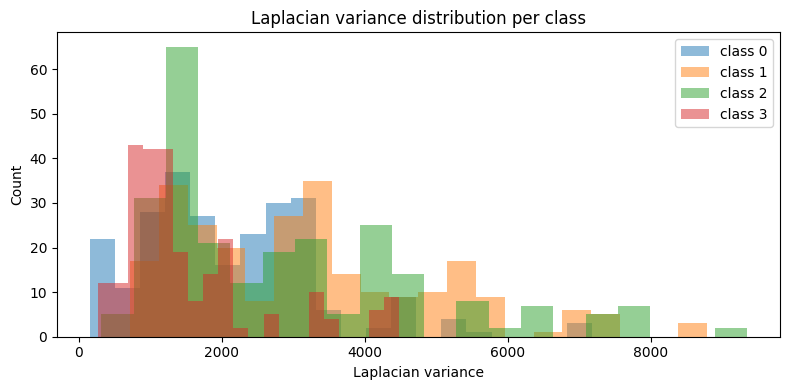

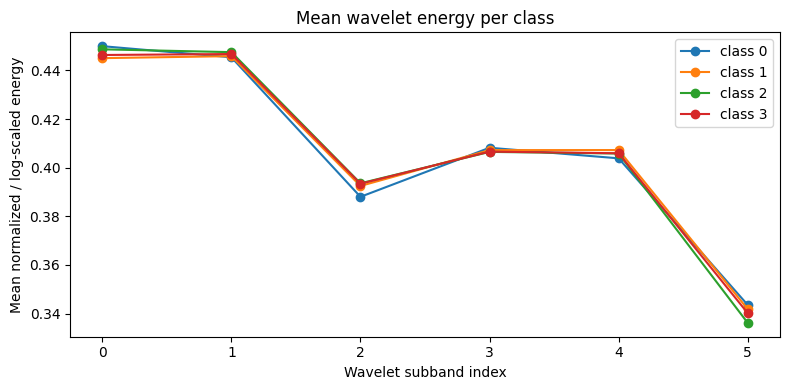

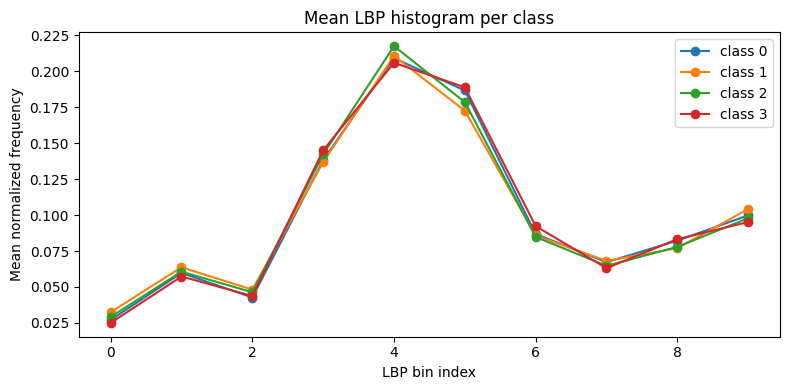

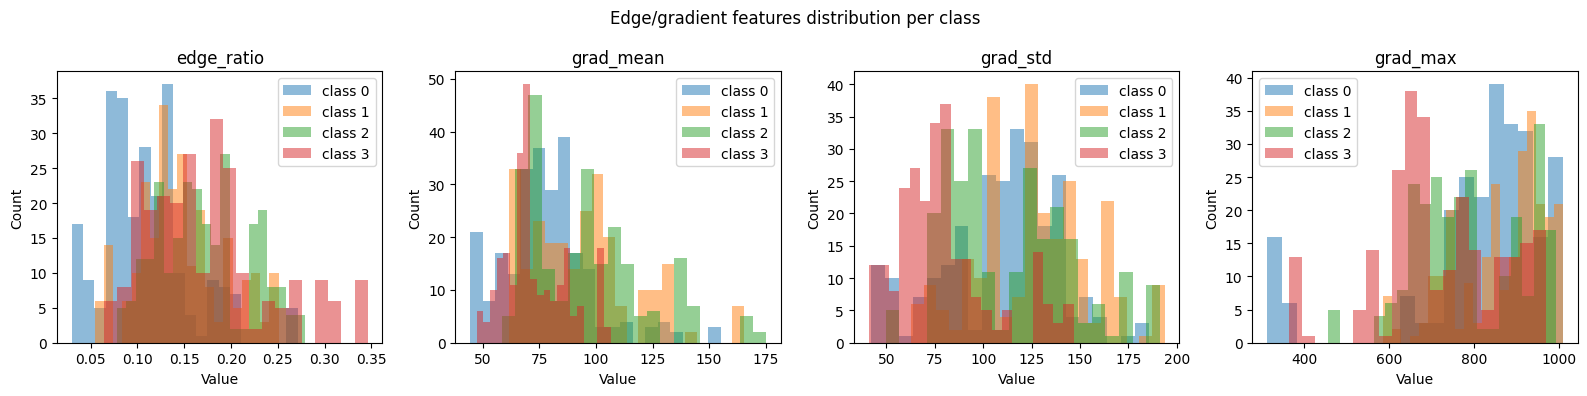

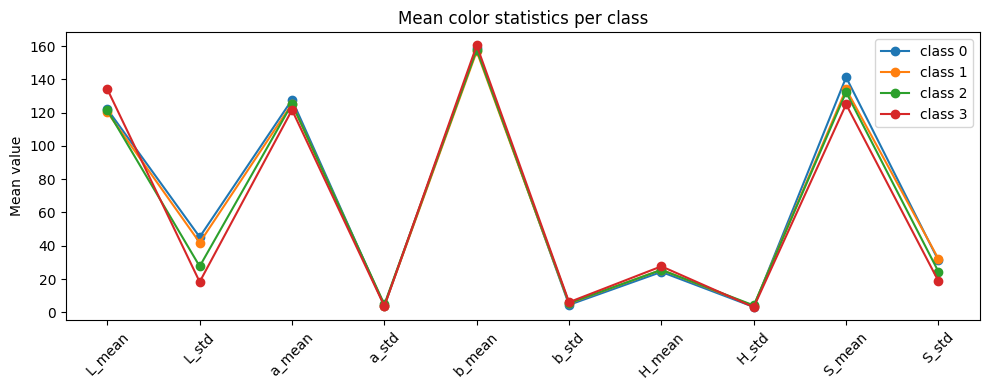

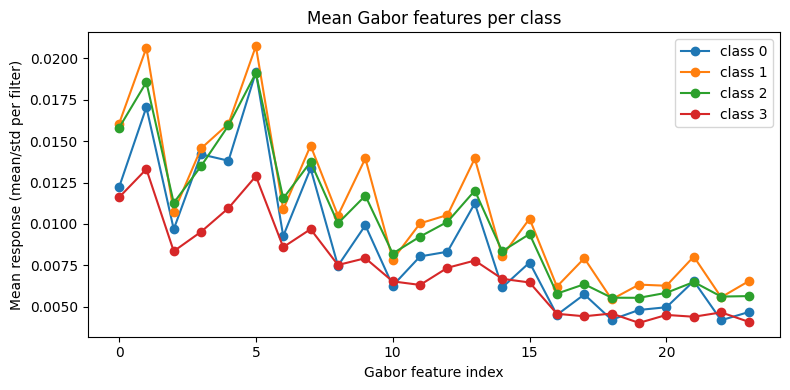

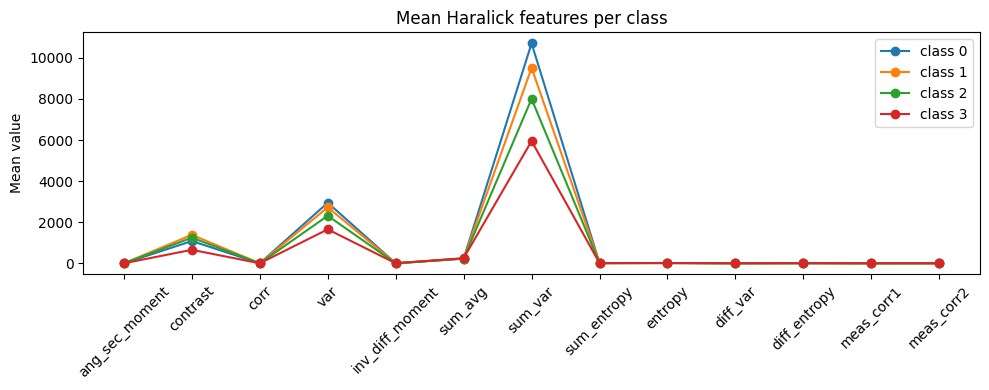

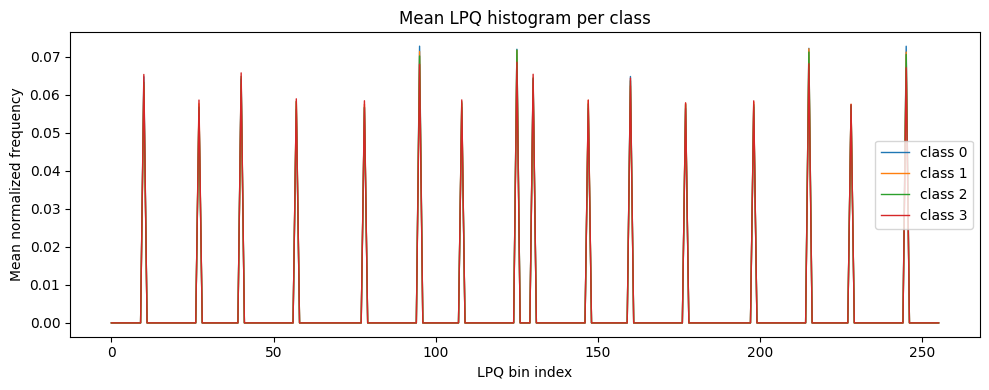

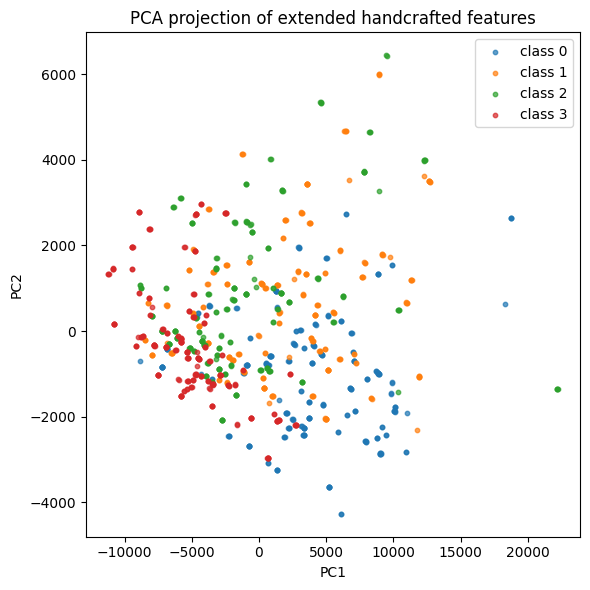

In [ ]:
#@title 5. Visualize / inspect features 
dummy_gray = np.zeros((224, 224), np.uint8)
dummy_bgr  = np.zeros((224, 224, 3), np.uint8)

glcm_dim   = glcm_features(dummy_gray).shape[0]
lap_dim    = 1
wav_dim    = wavelet_energy(dummy_gray).shape[0]
lbp_dim    = lbp_features(dummy_gray).shape[0]
edge_dim   = edge_features(dummy_gray).shape[0]
color_dim  = color_stats_features(dummy_bgr).shape[0]
gabor_dim  = gabor_features(dummy_gray).shape[0]
har_dim    = haralick_features(dummy_gray).shape[0]
lpq_dim    = lpq_features(dummy_gray).shape[0]

idx_glcm_start   = 0
idx_lap_start    = idx_glcm_start + glcm_dim
idx_wav_start    = idx_lap_start + lap_dim
idx_lbp_start    = idx_wav_start + wav_dim
idx_edge_start   = idx_lbp_start + lbp_dim
idx_color_start  = idx_edge_start + edge_dim
idx_gabor_start  = idx_color_start + color_dim
idx_har_start    = idx_gabor_start + gabor_dim
idx_lpq_start    = idx_har_start + har_dim

print("Feature block dimensions:")
print("  GLCM   :", glcm_dim)
print("  Lap    :", lap_dim)
print("  Wave   :", wav_dim)
print("  LBP    :", lbp_dim)
print("  Edge   :", edge_dim)
print("  Color  :", color_dim)
print("  Gabor  :", gabor_dim)
print("  Har    :", har_dim)
print("  LPQ    :", lpq_dim)


lap_values = X_features[:, idx_lap_start]

plt.figure(figsize=(8, 4))
for cls in range(4):
    vals = lap_values[y_labels == cls]
    plt.hist(vals, bins=20, alpha=0.5, label=f"class {cls}")
plt.xlabel("Laplacian variance")
plt.ylabel("Count")
plt.title("Laplacian variance distribution per class")
plt.legend()
plt.tight_layout()
plt.show()

wav_feats = X_features[:, idx_wav_start:idx_wav_start + wav_dim]

plt.figure(figsize=(8, 4))
for cls in range(4):
    cls_mean = wav_feats[y_labels == cls].mean(axis=0)
    plt.plot(cls_mean, marker='o', label=f"class {cls}")
plt.xlabel("Wavelet subband index")
plt.ylabel("Mean normalized / log-scaled energy")
plt.title("Mean wavelet energy per class")
plt.legend()
plt.tight_layout()
plt.show()

lbp_feats = X_features[:, idx_lbp_start:idx_lbp_start + lbp_dim]

plt.figure(figsize=(8, 4))
for cls in range(4):
    cls_mean = lbp_feats[y_labels == cls].mean(axis=0)
    plt.plot(cls_mean, marker='o', label=f"class {cls}")
plt.xlabel("LBP bin index")
plt.ylabel("Mean normalized frequency")
plt.title("Mean LBP histogram per class")
plt.legend()
plt.tight_layout()
plt.show()

edge_feats = X_features[:, idx_edge_start:idx_edge_start + edge_dim]
edge_names = ["edge_ratio", "grad_mean", "grad_std", "grad_max"]

fig, axes = plt.subplots(1, edge_dim, figsize=(4 * edge_dim, 4), sharey=False)
if edge_dim == 1:
    axes = [axes]

for i in range(edge_dim):
    ax = axes[i]
    for cls in range(4):
        vals = edge_feats[y_labels == cls, i]
        ax.hist(vals, bins=20, alpha=0.5, label=f"class {cls}")
    ax.set_title(edge_names[i] if i < len(edge_names) else f"edge_feat_{i}")
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend()

plt.suptitle("Edge/gradient features distribution per class")
plt.tight_layout()
plt.show()

color_feats = X_features[:, idx_color_start:idx_color_start + color_dim]

color_names = [
    "L_mean", "L_std",
    "a_mean", "a_std",
    "b_mean", "b_std",
    "H_mean", "H_std",
    "S_mean", "S_std"
]

plt.figure(figsize=(10, 4))
for cls in range(4):
    cls_mean = color_feats[y_labels == cls].mean(axis=0)
    plt.plot(cls_mean, marker='o', label=f"class {cls}")
plt.xticks(ticks=range(color_dim),
           labels=color_names[:color_dim],
           rotation=45)
plt.ylabel("Mean value")
plt.title("Mean color statistics per class")
plt.legend()
plt.tight_layout()
plt.show()

gabor_feats = X_features[:, idx_gabor_start:idx_gabor_start + gabor_dim]

plt.figure(figsize=(8, 4))
for cls in range(4):
    cls_mean = gabor_feats[y_labels == cls].mean(axis=0)
    plt.plot(cls_mean, marker='o', label=f"class {cls}")
plt.xlabel("Gabor feature index")
plt.ylabel("Mean response (mean/std per filter)")
plt.title("Mean Gabor features per class")
plt.legend()
plt.tight_layout()
plt.show()

har_feats = X_features[:, idx_har_start:idx_har_start + har_dim]
base_dim = 13
n_dist = har_dim // base_dim
har_feats_reshaped = har_feats.reshape(har_feats.shape[0], n_dist, base_dim)
har_feats_mean = har_feats_reshaped.mean(axis=1)  

har_names = [
    "ang_sec_moment", "contrast", "corr", "var", "inv_diff_moment",
    "sum_avg", "sum_var", "sum_entropy", "entropy", "diff_var",
    "diff_entropy", "meas_corr1", "meas_corr2"
]

plt.figure(figsize=(10, 4))
for cls in range(4):
    cls_mean = har_feats_mean[y_labels == cls].mean(axis=0)
    plt.plot(cls_mean, marker='o', label=f"class {cls}")
plt.xticks(ticks=range(base_dim),
           labels=har_names[:base_dim],
           rotation=45)
plt.ylabel("Mean value")
plt.title("Mean Haralick features per class")
plt.legend()
plt.tight_layout()
plt.show()

lpq_feats = X_features[:, idx_lpq_start:idx_lpq_start + lpq_dim]

plt.figure(figsize=(10, 4))
for cls in range(4):
    cls_mean = lpq_feats[y_labels == cls].mean(axis=0)
    plt.plot(cls_mean, label=f"class {cls}", linewidth=1)
plt.xlabel("LPQ bin index")
plt.ylabel("Mean normalized frequency")
plt.title("Mean LPQ histogram per class")
plt.tight_layout()
plt.legend()
plt.show()

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_features)

plt.figure(figsize=(6, 6))
colors_map = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
for cls in range(4):
    pts = X_pca[y_labels == cls]
    plt.scatter(pts[:, 0], pts[:, 1],
                s=10, alpha=0.7,
                label=f"class {cls}",
                c=colors_map[cls])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA projection of extended handcrafted features")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#@title 6. Pipeline A: handcrafted features + MLP classifier
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

mlp = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation="relu",
    max_iter=500,
    random_state=42
)

mlp.fit(X_train_scaled, y_train)
train_acc = mlp.score(X_train_scaled, y_train)
test_acc = mlp.score(X_test_scaled, y_test)

print(f"MLP Train accuracy: {train_acc:.4f}")
print(f"MLP Test accuracy : {test_acc:.4f}")

Train size: 800
Test size : 200
MLP Train accuracy: 1.0000
MLP Test accuracy : 0.8550


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [ ]:
#@title 7. Pipeline B: ResNet-18 on raw 224x224 images
train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])

base_dataset = ImageFolder(root=dataset_root, transform=None)
num_classes = len(base_dataset.classes)
print("Found classes:", base_dataset.classes)

val_ratio = 0.2
num_samples = len(base_dataset)
num_val = int(num_samples * val_ratio)
num_train = num_samples - num_val

train_dataset, val_dataset = random_split(
    base_dataset,
    [num_train, num_val],
    generator=torch.Generator().manual_seed(42)
)

class TransformWrapper(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        if self.transform is not None:
            img = self.transform(img)
        return img, label

train_dataset_tf = TransformWrapper(train_dataset, train_transform)
val_dataset_tf = TransformWrapper(val_dataset, val_transform)

train_loader = DataLoader(train_dataset_tf, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset_tf, batch_size=32, shuffle=False, num_workers=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Build ResNet-18 model
resnet = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features, num_classes)
resnet = resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)

Found classes: ['0', '1', '2', '3']
Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 85.6MB/s]


In [ ]:
#@title 8. Training loop for ResNet
def evaluate(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total if total > 0 else 0.0

num_epochs = 10

for epoch in range(num_epochs):
    resnet.train()
    running_loss = 0.0

    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = resnet(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    train_loss = running_loss / len(train_loader.dataset)
    train_acc = evaluate(resnet, train_loader, device)
    val_acc = evaluate(resnet, val_loader, device)

    print(f"Epoch {epoch+1:02d}/{num_epochs} "
          f"- Train loss: {train_loss:.4f} "
          f"- Train acc: {train_acc:.4f} "
          f"- Val acc: {val_acc:.4f}")

Epoch 01/10 - Train loss: 0.9183 - Train acc: 0.7500 - Val acc: 0.7500
Epoch 02/10 - Train loss: 0.4774 - Train acc: 0.8650 - Val acc: 0.8450
Epoch 03/10 - Train loss: 0.3571 - Train acc: 0.9175 - Val acc: 0.9000
Epoch 04/10 - Train loss: 0.2309 - Train acc: 0.9637 - Val acc: 0.9500
Epoch 05/10 - Train loss: 0.1788 - Train acc: 0.9688 - Val acc: 0.9050
Epoch 06/10 - Train loss: 0.1483 - Train acc: 0.9550 - Val acc: 0.8850
Epoch 07/10 - Train loss: 0.1416 - Train acc: 0.9563 - Val acc: 0.8800
Epoch 08/10 - Train loss: 0.1163 - Train acc: 0.9838 - Val acc: 0.9100
Epoch 09/10 - Train loss: 0.0932 - Train acc: 0.9838 - Val acc: 0.9350
Epoch 10/10 - Train loss: 0.0719 - Train acc: 0.9850 - Val acc: 0.9350


In [ ]:
#@title 9. Pipeline C: handcrafted features + SVM classifier
svm = SVC(
    kernel="rbf",
    C=10.0,
    gamma="scale",
    probability=True,  
    random_state=42
)

svm.fit(X_train_scaled, y_train)
train_acc_svm = svm.score(X_train_scaled, y_train)
test_acc_svm = svm.score(X_test_scaled, y_test)

print(f"SVM Train accuracy: {train_acc_svm:.4f}")
print(f"SVM Test accuracy : {test_acc_svm:.4f}")

SVM Train accuracy: 0.8988
SVM Test accuracy : 0.8250


In [ ]:
#@title 10. Deploy utilities: sliding-window inference + visualization
def infer_handcrafted_heatmap(full_bgr,
                              patch_size=224,
                              stride=112,
                              scaler=None,
                              clf=None):
    assert scaler is not None and clf is not None

    H, W = full_bgr.shape[:2]
    ys = list(range(0, H - patch_size + 1, stride))
    xs = list(range(0, W - patch_size + 1, stride))

    Gh = len(ys)
    Gw = len(xs)

    severity_grid = np.zeros((Gh, Gw), dtype=np.int32)
    prob_defect_grid = np.zeros((Gh, Gw), dtype=np.float32)

    for iy, y in enumerate(ys):
        for ix, x in enumerate(xs):

            patch_bgr = full_bgr[y:y+patch_size, x:x+patch_size]
            gray = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2GRAY)
            gray = cv2.resize(gray, (224, 224), interpolation=cv2.INTER_AREA)
            gray = cv2.normalize(gray, None, 0, 255, cv2.NORM_MINMAX)
            gray = gray.astype(np.uint8)

            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
            gray = clahe.apply(gray)

            gray = cv2.GaussianBlur(gray, (3, 3), 0)

            glcm_f = glcm_features(gray)
            lap_f = np.array([laplacian_variance(gray)], dtype=np.float32)
            wav_f = wavelet_energy(gray)

            feat = np.concatenate([glcm_f, lap_f, wav_f], axis=0).reshape(1, -1)

            feat_scaled = scaler.transform(feat)
            proba = clf.predict_proba(feat_scaled)[0]  

            pred_cls = int(np.argmax(proba))
            p_defect = 1.0 - float(proba[0])  

            severity_grid[iy, ix] = pred_cls
            prob_defect_grid[iy, ix] = p_defect

    return severity_grid, prob_defect_grid

def infer_resnet_heatmap(full_bgr,
                         patch_size=224,
                         stride=112,
                         resnet_model=None,
                         transform=None,
                         device=None):

    assert resnet_model is not None and transform is not None
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    H, W = full_bgr.shape[:2]
    ys = list(range(0, H - patch_size + 1, stride))
    xs = list(range(0, W - patch_size + 1, stride))

    Gh = len(ys)
    Gw = len(xs)

    severity_grid = np.zeros((Gh, Gw), dtype=np.int32)
    prob_defect_grid = np.zeros((Gh, Gw), dtype=np.float32)

    resnet_model.eval()
    resnet_model.to(device)

    with torch.no_grad():
        for iy, y in enumerate(ys):
            for ix, x in enumerate(xs):
                patch_bgr = full_bgr[y:y+patch_size, x:x+patch_size]
                patch_rgb = cv2.cvtColor(patch_bgr, cv2.COLOR_BGR2RGB)
                patch_pil = Image.fromarray(patch_rgb)

                inp = transform(patch_pil).unsqueeze(0).to(device)
                logits = resnet_model(inp)
                proba = torch.softmax(logits, dim=1).cpu().numpy()[0]

                pred_cls = int(np.argmax(proba))
                p_defect = 1.0 - float(proba[0])

                severity_grid[iy, ix] = pred_cls
                prob_defect_grid[iy, ix] = p_defect

    return severity_grid, prob_defect_grid

def visualize_heatmap_and_boxes(full_bgr,
                                severity_grid,
                                min_defect_level=1):

    H, W = full_bgr.shape[:2]
    Gh, Gw = severity_grid.shape

    severity_map = cv2.resize(severity_grid.astype(np.float32),
                              (W, H),
                              interpolation=cv2.INTER_NEAREST)

    severity_norm = severity_map / 3.0
    heatmap_color = cv2.applyColorMap(
        (severity_norm * 255).astype(np.uint8),
        cv2.COLORMAP_JET
    )
    overlay = cv2.addWeighted(full_bgr, 0.6, heatmap_color, 0.4, 0)

    mask_defect = (severity_map >= min_defect_level).astype(np.uint8)
    contours, _ = cv2.findContours(mask_defect,
                                   cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    vis_boxes = overlay.copy()
    defect_regions = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        region = severity_map[y:y+h, x:x+w]
        region_level = int(region.max())

        defect_regions.append({
            "x": x, "y": y, "w": w, "h": h,
            "severity": region_level
        })

        cv2.rectangle(vis_boxes, (x, y), (x+w, y+h), (0, 0, 255), 2)
        cv2.putText(vis_boxes, f"L{region_level}",
                    (x, y-5),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.7,
                    (0, 0, 255),
                    2)

    full_rgb = cv2.cvtColor(full_bgr, cv2.COLOR_BGR2RGB)
    vis_rgb = cv2.cvtColor(vis_boxes, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(full_rgb)
    plt.title("Original PCB")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(heatmap_color[:, :, ::-1])
    plt.title("Severity heatmap (0-3)")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(vis_rgb)
    plt.title("Detected corroded regions")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    print("Detected regions:")
    for i, r in enumerate(defect_regions):
        print(f"  #{i}: x={r['x']}, y={r['y']}, w={r['w']}, h={r['h']}, level={r['severity']}")

    return severity_map, defect_regions

Saving IMG_4396.jpg to IMG_4396 (2).jpg
Test image shape: (4032, 3024, 3)


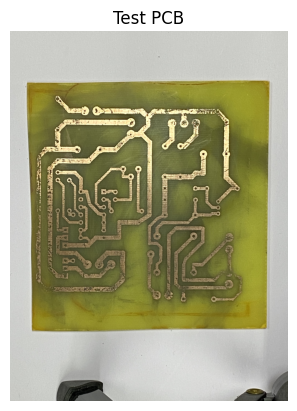

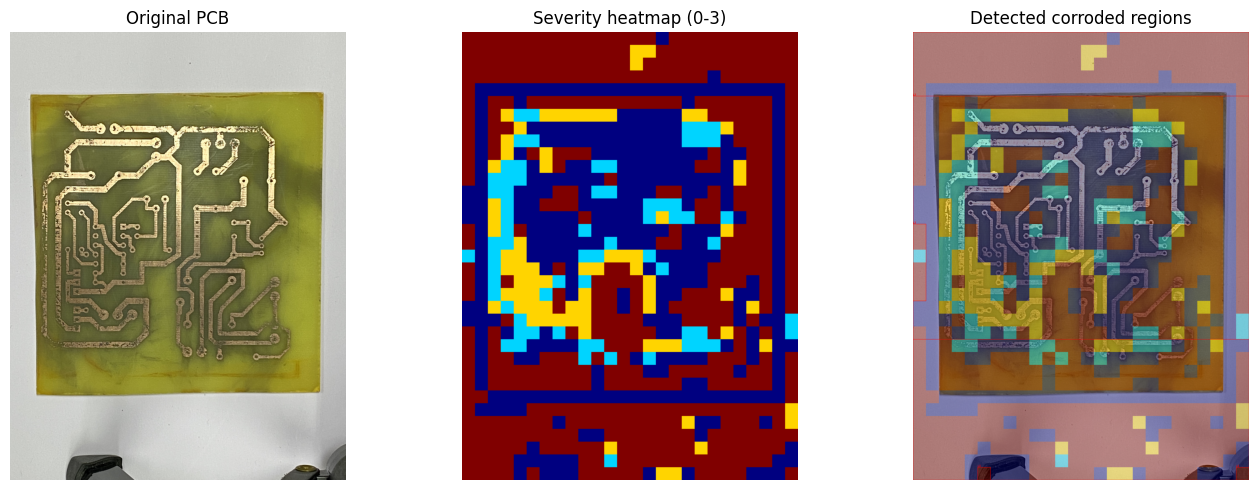

Detected regions:
  #0: x=2908, y=3917, w=116, h=115, level=3
  #1: x=582, y=3917, w=116, h=115, level=3
  #2: x=0, y=1728, w=117, h=692, level=3
  #3: x=0, y=576, w=3024, h=3456, level=3
  #4: x=0, y=0, w=3024, h=2765, level=3


In [ ]:
#@title 11. Deploy MLP on a new PCB image
from google.colab import files

uploaded = files.upload()
test_image_path = list(uploaded.keys())[0]

full_bgr = cv2.imread(test_image_path)
if full_bgr is None:
    raise FileNotFoundError(test_image_path)

print("Test image shape:", full_bgr.shape)
plt.imshow(cv2.cvtColor(full_bgr, cv2.COLOR_BGR2RGB))
plt.title("Test PCB")
plt.axis("off")
plt.show()

severity_grid_mlp, prob_grid_mlp = infer_handcrafted_heatmap(
    full_bgr,
    patch_size=224,
    stride=112,
    scaler=scaler,
    clf=mlp
)

severity_map_mlp, regions_mlp = visualize_heatmap_and_boxes(
    full_bgr,
    severity_grid_mlp,
    min_defect_level=1
)

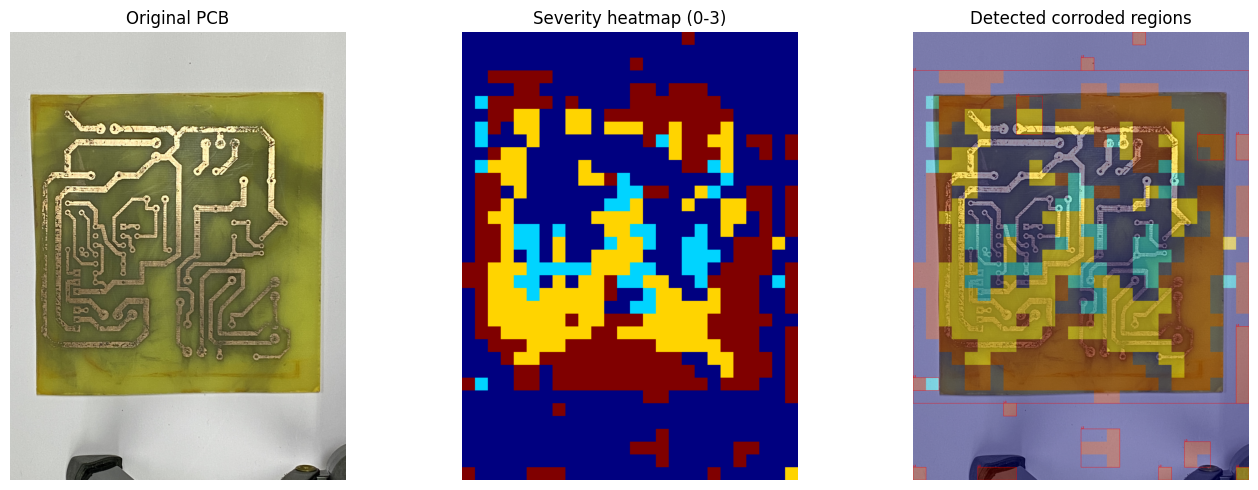

Detected regions:
  #0: x=2908, y=3917, w=116, h=115, level=2
  #1: x=2210, y=3917, w=117, h=115, level=3
  #2: x=582, y=3917, w=349, h=115, level=3
  #3: x=0, y=3917, w=117, h=115, level=3
  #4: x=2443, y=3687, w=233, h=230, level=3
  #5: x=1512, y=3572, w=349, h=345, level=3
  #6: x=815, y=3341, w=116, h=115, level=3
  #7: x=0, y=3111, w=233, h=115, level=3
  #8: x=2908, y=2650, w=116, h=691, level=3
  #9: x=2908, y=922, w=116, h=230, level=3
  #10: x=2559, y=922, w=233, h=230, level=3
  #11: x=931, y=576, w=233, h=346, level=3
  #12: x=0, y=346, w=3024, h=2995, level=3
  #13: x=1512, y=231, w=117, h=115, level=3
  #14: x=1978, y=0, w=116, h=116, level=3


In [ ]:
#@title 12. Deploy ResNet on the same PCB image
severity_grid_resnet, prob_grid_resnet = infer_resnet_heatmap(
    full_bgr,
    patch_size=224,
    stride=112,
    resnet_model=resnet,
    transform=val_transform,
    device=device
)

severity_map_resnet, regions_resnet = visualize_heatmap_and_boxes(
    full_bgr,
    severity_grid_resnet,
    min_defect_level=1
)

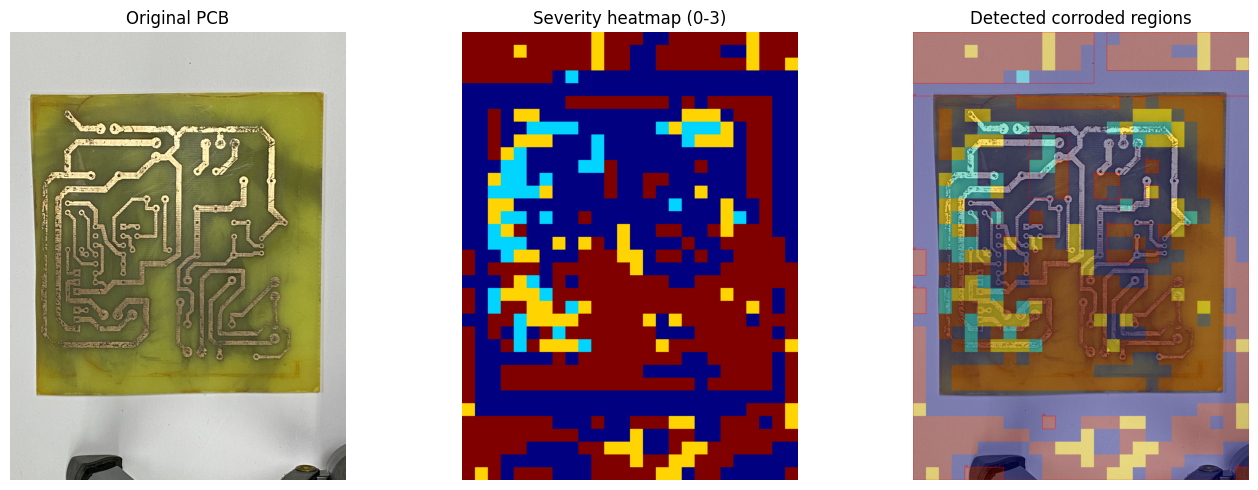

Detected regions:
  #0: x=2908, y=3917, w=116, h=115, level=3
  #1: x=466, y=3917, w=349, h=115, level=3
  #2: x=1164, y=3456, w=116, h=116, level=3
  #3: x=0, y=2304, w=117, h=231, level=3
  #4: x=0, y=1959, w=117, h=230, level=3
  #5: x=815, y=1844, w=116, h=115, level=2
  #6: x=1745, y=1728, w=465, h=346, level=3
  #7: x=1047, y=1613, w=117, h=115, level=3
  #8: x=698, y=1613, w=117, h=115, level=1
  #9: x=1861, y=1498, w=117, h=115, level=1
  #10: x=2094, y=1383, w=116, h=115, level=2
  #11: x=1629, y=1268, w=232, h=230, level=3
  #12: x=2094, y=1152, w=116, h=116, level=3
  #13: x=1047, y=922, w=349, h=576, level=3
  #14: x=0, y=576, w=3024, h=3456, level=3
  #15: x=931, y=576, w=930, h=116, level=3
  #16: x=1745, y=0, w=1279, h=346, level=3
  #17: x=0, y=0, w=1629, h=461, level=3


In [ ]:
#@title 13. Deploy SVM on the same PCB image
severity_grid_svm, prob_grid_svm = infer_handcrafted_heatmap(
    full_bgr,
    patch_size=224,
    stride=112,
    scaler=scaler,
    clf=svm
)

severity_map_svm, regions_svm = visualize_heatmap_and_boxes(
    full_bgr,
    severity_grid_svm,
    min_defect_level=1
)